In [7]:
import numpy as np 
import torch 
import math 
import matplotlib.pyplot as plt
from torch.optim import Optimizer
import time
from fastPLNmodels.VRA import SAGARAD,SAGRAD,SVRGRAD
from tqdm import tqdm 
import seaborn as sns

In [2]:
%load_ext autoreload

%autoreload 2

In [35]:
N_samples = 2000
p = 100
d = 40

In [48]:
X = torch.randn(N_samples, d)
true_beta = torch.randn(d,p)
true_alpha = torch.randn(d, p)
Y = X@true_beta + torch.randn(N_samples, p)*4
Y_bis = X@true_alpha + torch.randn(N_samples,p)*4 

In [49]:
def get_batch(X,Y,batch_size): 
    '''
    get the batches required to do a  minibatch gradient ascent.  

    args : 
            'batch_size' int.  the batch size you want. 

    returns : a generator. Will generate n/batch_size samples of size batch_size (except the last one 
                since the rest of the division is not always 0)
    '''
    #np.random.seed(2)
    n = Y.shape[0]
    indices = np.arange(n)
    np.random.shuffle(indices)
    # get the number of batches and the size of the last one. 
    nb_full_batch, last_batch_size  = n//batch_size, n % batch_size  
    for i in range(nb_full_batch): 
        yield   (X[indices[i*batch_size: (i+1)*batch_size]],
                 Y[indices[i*batch_size: (i+1)*batch_size]],
                 Y_bis[indices[i*batch_size: (i+1)*batch_size]],
                 indices[i*batch_size: (i+1)*batch_size]
                )
    if last_batch_size != 0 :
        yield   (X[indices[-last_batch_size:]], Y[indices[-last_batch_size:]],
                  Y_bis[indices[-last_batch_size:]],indices[-last_batch_size:],
                )
        


In [43]:
def f(x,y_i): 
    return 1/2*torch.norm(x@beta-y_i)**2

def F(beta): 
    return 1/2*torch.mean(torch.norm(Y-X@beta, dim = (1))**2)

def F_bis(alpha): 
    return 1/2*torch.mean(torch.norm(Y_bis-X@alpha, dim = (1))**2)
def grad_f(beta,y_i,x_i): 
    return -torch.outer(x_i, y_i-x_i@beta)
def grad_f_bis(alpha,y_i,x_i): 
    return -torch.outer(x_i, y_i-x_i@beta)

def grad_F(beta): 
    return -torch.mean(torch.matmul(X.unsqueeze(2), (Y-X@beta).unsqueeze(1)) , axis = 0)
def grad_F_bis(alpha): 
    return -torch.mean(torch.matmul(X.unsqueeze(2), (Y_bis-X@alpha).unsqueeze(1)) , axis = 0)
    
def batch_grad(beta,x_batch, y_batch): 
    return -torch.matmul(x_batch.unsqueeze(2), (y_batch-x_batch@beta).unsqueeze(1))
def batch_grad_bis(alpha,x_batch, y_batch): 
    return -torch.matmul(x_batch.unsqueeze(2), (y_batch-x_batch@alpha).unsqueeze(1))


def fit(nb_step, choice_optim, lr, batch_size, vr_bool):
    beta = torch.zeros((d,p),requires_grad = True)
    alpha = torch.zeros((d,p), requires_grad = True)
    alpha.requires_grad_(True)
    optim = choice_optim([alpha,beta], lr = lr) 
    MSE_alpha_list = []
    MSE_beta_list = []
    running_times = []
    t0 = time.time()
    if vr_bool : 
        vr = SAGARAD([alpha, beta], N_samples)
    for i in tqdm(range(nb_step)):
        for x_b,y_b,y_b_bis, selected_indices in get_batch(X,Y, batch_size): 
            
            batch_grad_alpha = batch_grad(alpha, x_b,y_b_bis)
            batch_grad_beta = batch_grad(beta, x_b, y_b) 
            if vr_bool : 
                vr.update_new_grad([batch_grad_alpha, batch_grad_beta], selected_indices)
            else : 
                alpha.grad = torch.mean(batch_grad_alpha, axis = 0)
                beta.grad = torch.mean(batch_grad_beta, axis = 0)
            
            optim.step()
                #print('time others', time.time()-t)
            MSE_alpha_list.append(torch.mean((alpha-true_alpha)**2).item())
            MSE_beta_list.append(torch.mean((beta-true_beta)**2).item())
            running_times.append(time.time()-t0)
            optim.zero_grad()
        
    return MSE_alpha_list, MSE_beta_list, running_times

In [83]:
MSE_alpha_VR, MSE_beta_VR, running_VR = fit(10,torch.optim.Adagrad, 0.1, 50, vr_bool = True)
print('MSE_alpha', np.mean(MSE_alpha_VR[-200:]))
print('MSE_beta', np.mean(MSE_beta_VR[-200:]))

100%|██████████| 10/10 [00:00<00:00, 14.39it/s]

MSE_alpha 0.024792741006240248
MSE_beta 0.030462888637557625


In [82]:
MSE_alpha_noVR, MSE_beta_noVR, running_noVR = fit(10,torch.optim.Adagrad, 0.1, 50, vr_bool = False)
print('MSE_alpha', np.mean(MSE_alpha_noVR[-200:]))
print('MSE_beta', np.mean(MSE_beta_noVR[-200:]))

100%|██████████| 10/10 [00:00<00:00, 18.30it/s]

MSE_alpha 0.016187775218859314
MSE_beta 0.01987485204357654


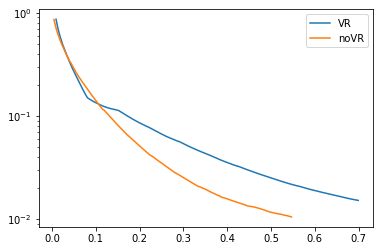

In [84]:
show(MSE_alpha_VR, MSE_alpha_noVR, running_VR, running_noVR, ['VR', 'noVR'])

100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


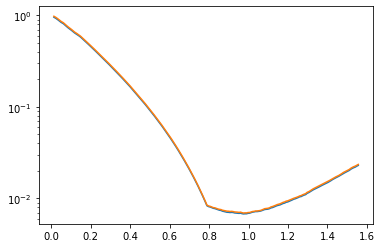

MSE_alpha 0.13533891117665917
MSE_beta 0.138452089948114


In [69]:
MSE_alpha_SAGA, MSE_beta_SAGA, running_SAGA = fit(True,False,  2, SAGA, 0.008, 100)
show(MSE_alpha_SAGA, MSE_beta_SAGA, running_SAGA)
print('MSE_alpha', np.mean(MSE_alpha_SAGA[-200:]))
print('MSE_beta', np.mean(MSE_beta_SAGA[-200:]))

In [74]:
def show(first_MSE, sec_MSE, first_running_times, sec_running_times, names): 
    plt.plot(first_running_times, first_MSE, label = names[0] )
    plt.plot(sec_running_times, sec_MSE, label = names[1] )
    plt.yscale('log')
    plt.legend()
    plt.show()
    


shape torch.Size([300, 4, 10])
dims : [torch.Size([4, 10]), torch.Size([4, 10])]
MSE :  tensor(0.0440, grad_fn=<MeanBackward0>)
MSE :  tensor(0.0694, grad_fn=<MeanBackward0>)


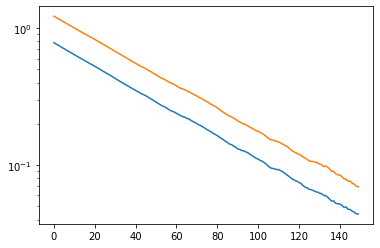

In [116]:
alpha = torch.zeros(d,p,requires_grad = True)
beta = torch.zeros(d,p ,requires_grad = True)
init_grad_alpha = batch_grad(alpha, X, Y_bis)
init_grad_beta = batch_grad(beta, X, Y)
init_grads = [init_grad_alpha, init_grad_beta]
saga = SAGA([alpha,beta],init_grads, 0.01)
MSE_alpha_list = []
MSE_beta_list = []
for i in range(5): 
    for x_b,y_b,y_b_bis, selected_indices in get_batch(X,Y, 10): 
        batch_grad_alpha = batch_grad(alpha, x_b,y_b_bis)
        batch_grad_beta = batch_grad(beta, x_b, y_b)
        alpha.grad = torch.mean(batch_grad_alpha, axis = 0)
        beta.grad = torch.mean(batch_grad_beta, axis = 0)
        saga.step([batch_grad_alpha,batch_grad_beta], selected_indices)
        MSE_alpha_list.append(torch.mean((alpha-true_alpha)**2))
        MSE_beta_list.append(torch.mean((beta-true_beta)**2))
        
plt.plot(np.arange(0, len(MSE_alpha_list)), MSE_alpha_list)
plt.plot(np.arange(0, len(MSE_beta_list)), MSE_beta_list)
plt.yscale('log')
print('MSE : ', MSE_alpha_list[-1])
print('MSE : ', MSE_beta_list[-1])
#saga.step(1)

In [70]:
y = torch.zeros((15,4), requires_grad = True)
y_bis = torch.zeros((8,6), requires_grad = True)

In [71]:
true_alpha

tensor([[ 0.2914,  0.9492, -0.3462,  0.5065, -1.1999, -1.0172,  1.2064,  0.6506,
         -1.5739,  0.8133],
        [-0.4434,  1.1968,  0.2454, -0.5643,  0.9045, -0.3705,  1.6797,  1.3262,
          1.4530, -1.0903],
        [ 0.0062, -0.0218, -1.2418, -0.8894, -1.1913,  0.6112,  0.0321,  0.8183,
         -1.2064,  0.4688],
        [-0.4059, -0.3626,  0.5432,  1.2395, -0.5273,  0.8417,  0.5511, -1.4600,
          0.3286,  0.3510]])

In [73]:
first_init = torch.cat((2*(y-2).unsqueeze(0), 2*(y-1).unsqueeze(0), 2*(y-4).unsqueeze(0)),0)
second_init = torch.cat((2*(y_bis-2).unsqueeze(0), 2*(y_bis-1).unsqueeze(0), 2*(y_bis-4).unsqueeze(0)),0)
print(first_init.shape)
init_grads = [first_init, second_init]

torch.Size([3, 15, 4])
